# Predictive Modeling of Slope Stability: A Comparative Analysis
**Student:** Daniel Mateu
**Course:** Geotechnical Engineering — Dr. Song

**Extended version with analysis extras:**
* Auto-detected champion used everywhere (no hard-coding)
* Safe AUC everywhere (handles single-class splits)
* Clean plot exports (tight_layout)
* K‑Fold CV leaderboard (Stratified)
* ROC curves for Top‑3 models
* Optional SHAP explainability (skips gracefully if unavailable)
* Hyperparameter search with GridSearchCV (small, sensible grids)
* Autosave metrics table (CSV)
* Save final champion as a pickle (joblib)
* One‑click PDF report bundling all plots (PdfPages)

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump
from matplotlib.backends.backend_pdf import PdfPages

# --- I/O folders ---
DATA_DIR = Path("data")
PLOTS_DIR = Path("plots")
MODELS_DIR = Path("models")
REPORTS_DIR = Path("reports")
for d in [PLOTS_DIR, MODELS_DIR, REPORTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# --- Step 1: Load & Clean ---
file_path = DATA_DIR / "Dataset.xlsx"
if not file_path.exists():
    raise FileNotFoundError(f"Could not find: {file_path.resolve()}")

df = pd.read_excel(file_path)
print("Original Column Names:", list(df.columns))

expected_cols = 8
assert df.shape[1] == expected_cols, f"Expected {expected_cols} columns, got {df.shape[1]}"

df.columns = [
    'no',
    'unit_weight_kn_m3',
    'cohesion_kpa',
    'friction_angle_deg',
    'slope_angle_deg',
    'height_m',
    'pore_pressure_ratio_ru',
    'status'
]

print("\nCleaned column names:", list(df.columns))
print("\ndata Head:\n", df.head())
print("\nDataFrame Info:")
df.info()
print("\nMissing Values Count:\n", df.isnull().sum())

Original Column Names: ['No', '𝜸(kN/m3)', 'c (kPa)', '𝝋(°)', '𝜷\xa0(°)', 'H (m)', '𝒓𝒖', 'Status']

Cleaned column names: ['no', 'unit_weight_kn_m3', 'cohesion_kpa', 'friction_angle_deg', 'slope_angle_deg', 'height_m', 'pore_pressure_ratio_ru', 'status']

data Head:
    no  unit_weight_kn_m3  cohesion_kpa  friction_angle_deg  slope_angle_deg  \
0   1              17.98          4.95               30.02            19.98   
1   2              18.00          5.00               30.00            20.00   
2   3              21.47          6.90               30.02            31.01   
3   4              21.51          6.94               30.00            31.00   
4   5              21.78          8.55               32.00            27.98   

   height_m  pore_pressure_ratio_ru   status  
0      8.00                    0.30   Stable  
1      8.00                    0.30   Stable  
2     76.80                    0.38  Failure  
3     76.81                    0.38  Failure  
4     12.80            

## Phase 2: Target Engineering & EDA

In [5]:
# --- Step 2: Target & Numeric Coercion ---
df['status'] = df['status'].astype(str).str.strip().str.title()
df['is_stable'] = (df['status'] == 'Stable').astype(int)

num_cols = ['unit_weight_kn_m3','cohesion_kpa','friction_angle_deg',
            'slope_angle_deg','height_m','pore_pressure_ratio_ru']

df[num_cols] = df[num_cols].apply(pd.to_numeric, errors='coerce')
na_counts = df[num_cols + ['is_stable']].isna().sum()
if na_counts.any():
    print("\nDropping rows with NaNs:", na_counts[na_counts > 0].to_dict())
    df = df.dropna(subset=num_cols + ['is_stable'])

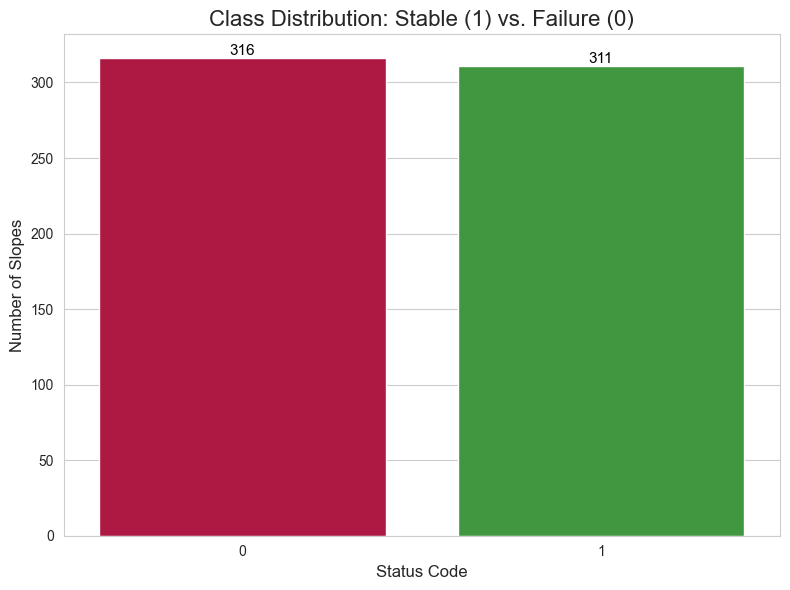

In [20]:
# --- Step 3: EDA Plots ---
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='is_stable', data=df, palette=['#C70039', '#33A532'])
ax.set_title('Class Distribution: Stable (1) vs. Failure (0)', fontsize=16)
ax.set_xlabel('Status Code', fontsize=12)
ax.set_ylabel('Number of Slopes', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x()+p.get_width()/2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.tight_layout()
plt.savefig(PLOTS_DIR/"class_distribution.png")
plt.show()

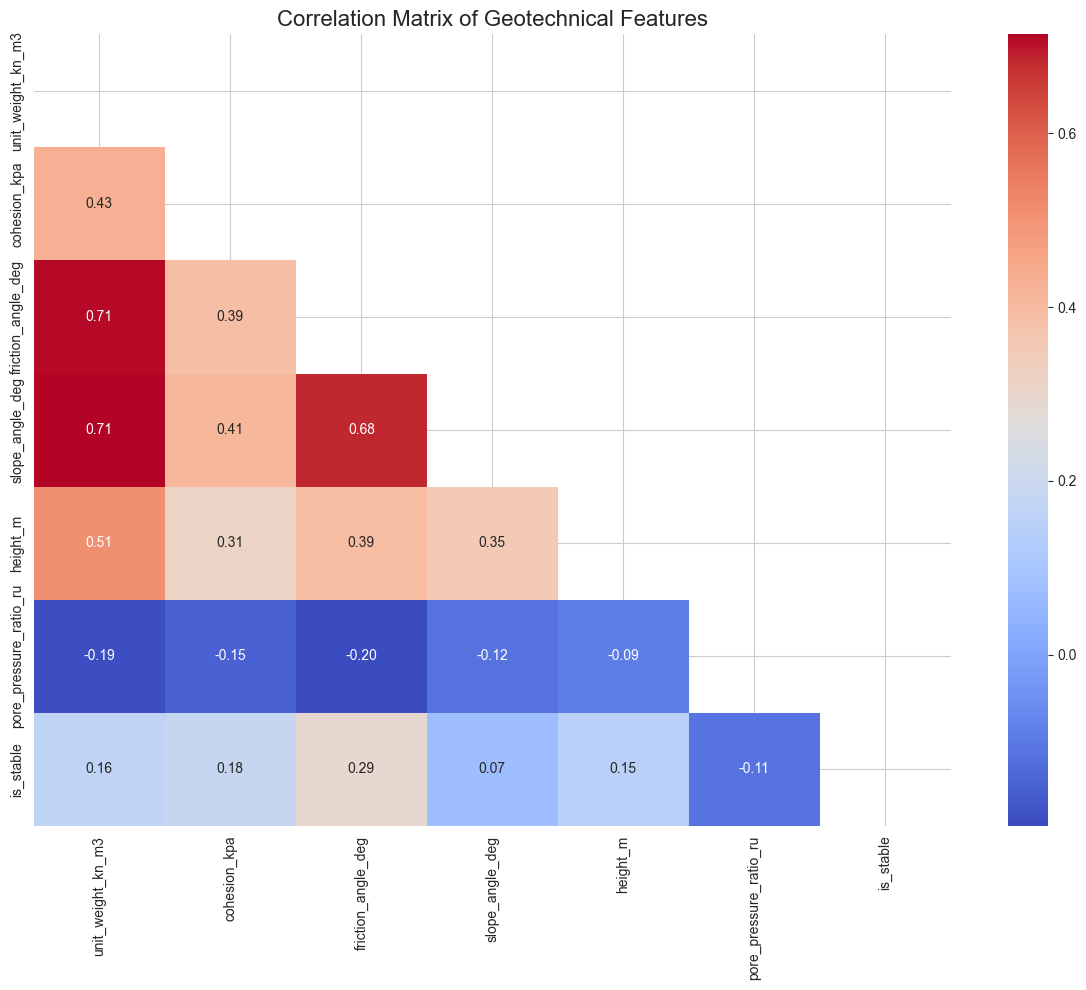

In [7]:
corr = df[num_cols + ['is_stable']].corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Geotechnical Features', fontsize=16)
plt.tight_layout()
plt.savefig(PLOTS_DIR/"correlation_matrix.png")
plt.show()

## Phase 3: Modeling Setup & 80/20 Split

In [8]:
# --- Step 4: Modeling Setup ---
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.metrics import (
    classification_report, roc_auc_score, ConfusionMatrixDisplay,
    RocCurveDisplay
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier

# --- Utils ---
def safe_auc(y_true, y_score):
    """Guard AUC in case a class disappears in a small test split."""
    from sklearn.metrics import roc_auc_score as _roc_auc
    if len(np.unique(y_true)) < 2:
        return float("nan")
    return _roc_auc(y_true, y_score)

X = df[num_cols]
y = df['is_stable']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "KNN": Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier())
    ]),
    "Decision Tree": Pipeline([
        ('model', DecisionTreeClassifier(random_state=42))
    ]),
    "SVM": Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(probability=True, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ('model', RandomForestClassifier(n_estimators=300, random_state=42))
    ]),
    "Gradient Boosting": Pipeline([
        ('model', GradientBoostingClassifier(random_state=42))
    ]),
    "XGBoost": Pipeline([
        ('model', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"))
    ])
}

## Phase 4: Model Bake-Off & Stacking (80/20)

In [9]:
# --- Step 5: Model Bake-Off (80/20) ---
trained_models = {}
all_results = {}

print("\n--- Model Bake-Off (80/20) ---")
for name, pipe in models.items():
    print(f"Training {name}")
    pipe.fit(X_train, y_train)
    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    rep = classification_report(y_test, y_pred, output_dict=True)
    rep["auc"] = safe_auc(y_test, y_proba)
    trained_models[name] = pipe
    all_results[name] = rep

summary_rows = []
for m, rep in all_results.items():
    wa = rep["weighted avg"]
    summary_rows.append({
        "Model": m, "AUC": rep["auc"],
        "F1-Score": wa["f1-score"], "Precision": wa["precision"], "Recall": wa["recall"]
    })
results_df = pd.DataFrame(summary_rows).sort_values(by="AUC", ascending=False)
print("\nLeaderboard (80/20):\n", results_df)

# Save numeric leaderboard
results_df.to_csv(REPORTS_DIR/"results_80_20.csv", index=False)


--- Model Bake-Off (80/20) ---
Training Logistic Regression
Training KNN
Training Decision Tree
Training SVM
Training Random Forest
Training Gradient Boosting
Training XGBoost

Leaderboard (80/20):
                  Model       AUC  F1-Score  Precision    Recall
4        Random Forest  0.915953  0.833302   0.833375  0.833333
6              XGBoost  0.891003  0.777778   0.777778  0.777778
5    Gradient Boosting  0.887475  0.800798   0.808300  0.801587
1                  KNN  0.870842  0.801600   0.801713  0.801587
3                  SVM  0.810358  0.783044   0.797774  0.785714
2        Decision Tree  0.793221  0.769332   0.771264  0.769841
0  Logistic Regression  0.683594  0.634736   0.634873  0.634921


In [10]:
# --- Step 6: Stacking Ensemble ---
base_learners = [
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42)),
    ("gb", GradientBoostingClassifier(random_state=42)),
    ("xgb", XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")),
]
meta_learner = LogisticRegression(random_state=42, max_iter=1000)
stack = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)
print("\nTraining Stacking Ensemble...")
stack.fit(X_train, y_train)
y_pred_s  = stack.predict(X_test)
y_proba_s = stack.predict_proba(X_test)[:, 1]
rep_s = classification_report(y_test, y_pred_s, output_dict=True)
rep_s["auc"] = safe_auc(y_test, y_proba_s)
trained_models["Stacking Ensemble"] = stack
all_results["Stacking Ensemble"] = rep_s

# Rebuild leaderboard including stacking
rows = []
for m, rep in all_results.items():
    wa = rep["weighted avg"]
    rows.append({"Model": m, "AUC": rep["auc"], "F1-Score": wa["f1-score"], "Precision": wa["precision"], "Recall": wa["recall"]})
results_df_final = pd.DataFrame(rows).sort_values(by="AUC", ascending=False)
print("\nFinal Leaderboard (80/20 + Stacking):\n", results_df_final)
results_df_final.to_csv(REPORTS_DIR/"results_final_80_20.csv", index=False)


Training Stacking Ensemble...

Final Leaderboard (80/20 + Stacking):
                  Model       AUC  F1-Score  Precision    Recall
4        Random Forest  0.915953  0.833302   0.833375  0.833333
7    Stacking Ensemble  0.910660  0.817472   0.817586  0.817460
6              XGBoost  0.891003  0.777778   0.777778  0.777778
5    Gradient Boosting  0.887475  0.800798   0.808300  0.801587
1                  KNN  0.870842  0.801600   0.801713  0.801587
3                  SVM  0.810358  0.783044   0.797774  0.785714
2        Decision Tree  0.793221  0.769332   0.771264  0.769841
0  Logistic Regression  0.683594  0.634736   0.634873  0.634921


## Phase 5: Champion Model Analysis (80/20 & 70/30)


Champion model: Random Forest


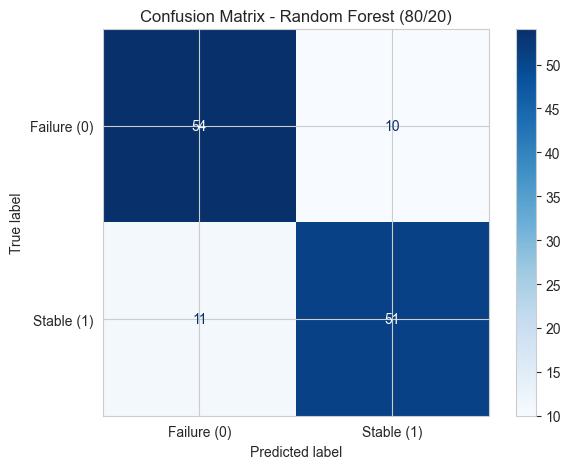

In [11]:
# --- Step 7: Confusion Matrix for Champion (80/20) ---
champion_name = results_df_final.iloc[0]["Model"]
champion_model_pipeline = trained_models[champion_name]
print(f"\nChampion model: {champion_name}")

y_pred_champ = champion_model_pipeline.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_champ,
    display_labels=["Failure (0)", "Stable (1)"], cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - {champion_name} (80/20)")
plt.tight_layout()
plt.savefig(PLOTS_DIR/"confusion_matrix_80_20.png")
plt.show()


--- 70/30 Robustness with Champion ---
AUC (70/30): 0.9163

Classification Report (70/30):
               precision    recall  f1-score   support

           0       0.84      0.85      0.84        95
           1       0.85      0.83      0.84        94

    accuracy                           0.84       189
   macro avg       0.84      0.84      0.84       189
weighted avg       0.84      0.84      0.84       189



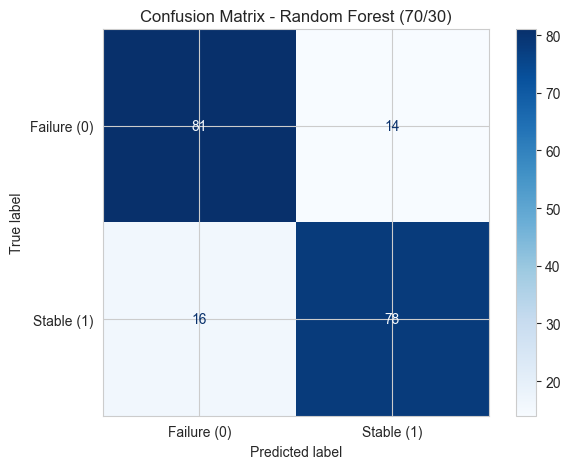

In [12]:
# --- Step 8: 70/30 Robustness using actual Champion ---
print("\n--- 70/30 Robustness with Champion ---")
X_tr7030, X_te7030, y_tr7030, y_te7030 = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Clone the champion pipeline to retrain on new data
champion_7030 = clone(champion_model_pipeline)
champion_7030.fit(X_tr7030, y_tr7030)

y_pred_7030  = champion_7030.predict(X_te7030)
y_proba_7030 = champion_7030.predict_proba(X_te7030)[:, 1]
auc_7030 = safe_auc(y_te7030, y_proba_7030) # Use safe_auc

print(f"AUC (70/30): {auc_7030:.4f}\n")
print("Classification Report (70/30):\n", classification_report(y_te7030, y_pred_7030))
ConfusionMatrixDisplay.from_predictions(y_te7030, y_pred_7030,
    display_labels=["Failure (0)", "Stable (1)"], cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix - {champion_name} (70/30)")
plt.tight_layout()
plt.savefig(PLOTS_DIR/"confusion_matrix_70_30.png")
plt.show()

## Phase 6: Advanced Validation (K-Fold & ROC)

In [13]:
# --- Step 9: Stratified K-Fold CV Leaderboard (AUC) ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_rows = []
for name, pipe in models.items():
    # We evaluate only base set (stacking can be expensive in CV)
    print(f"Running CV for {name}...")
    aucs = cross_val_score(pipe, X, y, scoring='roc_auc', cv=skf, n_jobs=-1)
    cv_rows.append({"Model": name, "CV AUC Mean": np.mean(aucs), "CV AUC Std": np.std(aucs)})

cv_df = pd.DataFrame(cv_rows).sort_values(by="CV AUC Mean", ascending=False)
print("\nStratified 5‑Fold CV AUC Leaderboard:\n", cv_df)
cv_df.to_csv(REPORTS_DIR/"cv_auc_leaderboard.csv", index=False)

Running CV for Logistic Regression...
Running CV for KNN...
Running CV for Decision Tree...
Running CV for SVM...
Running CV for Random Forest...
Running CV for Gradient Boosting...
Running CV for XGBoost...

Stratified 5‑Fold CV AUC Leaderboard:
                  Model  CV AUC Mean  CV AUC Std
4        Random Forest     0.929759    0.028132
6              XGBoost     0.921585    0.026723
5    Gradient Boosting     0.906957    0.030038
1                  KNN     0.873640    0.022186
2        Decision Tree     0.821046    0.035953
3                  SVM     0.811198    0.019464
0  Logistic Regression     0.721026    0.037758



Generating ROC Curves for Top 3 Models...


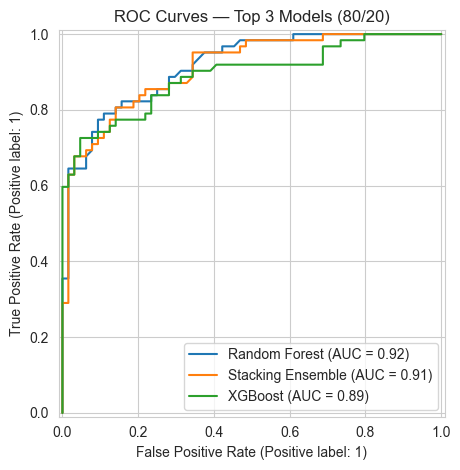

In [14]:
# --- Step 10: ROC Curves for Top‑3 models by 80/20 AUC ---
print("\nGenerating ROC Curves for Top 3 Models...")
roc_top3 = results_df_final.head(3)["Model"].tolist()
plt.figure()
ax = plt.gca()
for name in roc_top3:
    pipe = trained_models[name]
    RocCurveDisplay.from_estimator(pipe, X_test, y_test, name=name, ax=ax)

plt.title("ROC Curves — Top 3 Models (80/20)")
plt.tight_layout()
plt.savefig(PLOTS_DIR/"roc_top3.png")
plt.show()

## Phase 7: Hyperparameter Tuning (GridSearchCV)

In [15]:
# --- Step 11: Hyperparameter Search (GridSearchCV) ---
print("\n--- Starting Hyperparameter Grid Search ---")

search_spaces = {
    "Logistic Regression": {
        'model__C': [0.1, 1.0, 10.0],
        'model__penalty': ['l2'],
        'model__solver': ['lbfgs']
    },
    "SVM": {
        'model__C': [0.5, 1.0, 2.0],
        'model__gamma': ['scale', 'auto']
    },
    "Random Forest": {
        'model__n_estimators': [200, 400],
        'model__max_depth': [None, 6, 12],
        'model__min_samples_split': [2, 5]
    },
    "XGBoost": {
        'model__n_estimators': [200, 400],
        'model__max_depth': [3, 5],
        'model__learning_rate': [0.05, 0.1]
    }
}

best_grid_models = {}
for name, pipe in models.items():
    if name not in search_spaces:
        continue
    print(f"\nGrid search for {name}...")
    gs = GridSearchCV(pipe, search_spaces[name], scoring='roc_auc', cv=skf, n_jobs=-1)
    gs.fit(X_train, y_train)
    print("Best params:", gs.best_params_)
    print("Best CV AUC:", gs.best_score_)
    best_grid_models[name] = gs.best_estimator_

# Evaluate best grid winners on the test set
grid_rows = []
for name, est in best_grid_models.items():
    y_pred = est.predict(X_test)
    y_prob = est.predict_proba(X_test)[:, 1]
    rep = classification_report(y_test, y_pred, output_dict=True)
    rep_auc = safe_auc(y_test, y_prob)
    grid_rows.append({
        "Model": name + " (Grid)",
        "AUC": rep_auc,
        "F1-Score": rep['weighted avg']['f1-score'],
        "Precision": rep['weighted avg']['precision'],
        "Recall": rep['weighted avg']['recall']
    })

if grid_rows:
    grid_df = pd.DataFrame(grid_rows).sort_values(by="AUC", ascending=False)
    print("\nGrid Search Winners (Test Performance):\n", grid_df)
    grid_df.to_csv(REPORTS_DIR/"grid_winners_80_20.csv", index=False)
else:
    print("\nNo grid searches ran (no matching models).")


--- Starting Hyperparameter Grid Search ---

Grid search for Logistic Regression...
Best params: {'model__C': 10.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
Best CV AUC: 0.7275765666266507

Grid search for SVM...
Best params: {'model__C': 2.0, 'model__gamma': 'scale'}
Best CV AUC: 0.8190970148059223

Grid search for Random Forest...
Best params: {'model__max_depth': 12, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV AUC: 0.9347169587835132

Grid search for XGBoost...
Best params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 400}
Best CV AUC: 0.918634349739896

Grid Search Winners (Test Performance):
                         Model       AUC  F1-Score  Precision    Recall
2        Random Forest (Grid)  0.908140  0.817426   0.818319  0.817460
3              XGBoost (Grid)  0.897807  0.809524   0.809524  0.809524
1                  SVM (Grid)  0.822203  0.776651   0.781893  0.777778
0  Logistic Regression (Grid)  0.684350  0.6347

## Phase 8: Explainability & Persistence


--- Feature Importances from Random Forest ---
                  Feature  Importance
1            cohesion_kpa    0.206557
0       unit_weight_kn_m3    0.203268
2      friction_angle_deg    0.181124
4                height_m    0.171053
3         slope_angle_deg    0.142352
5  pore_pressure_ratio_ru    0.095646


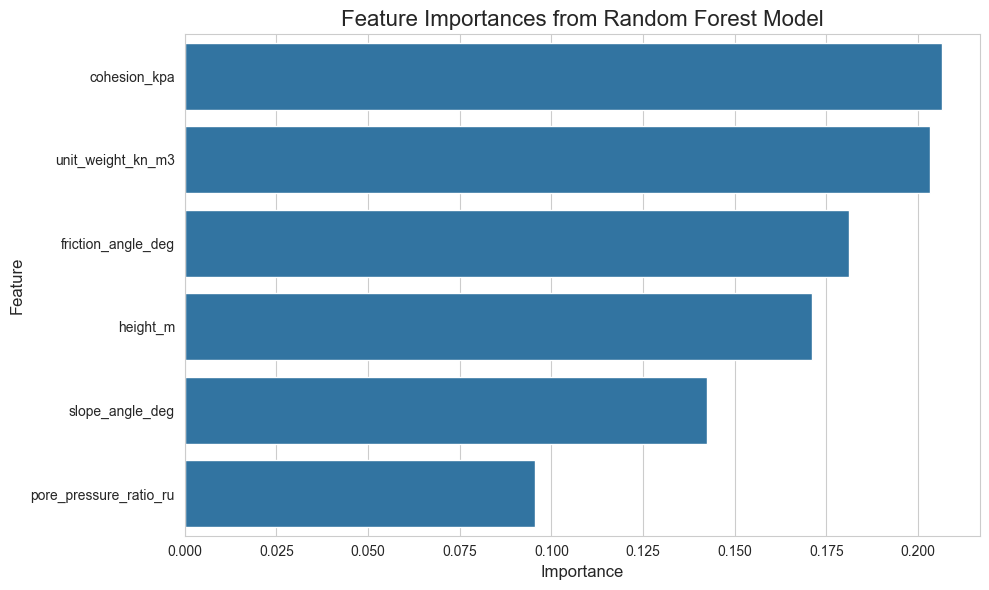


--- Generating Partial Dependence Plots for: ['cohesion_kpa', 'unit_weight_kn_m3'] ---


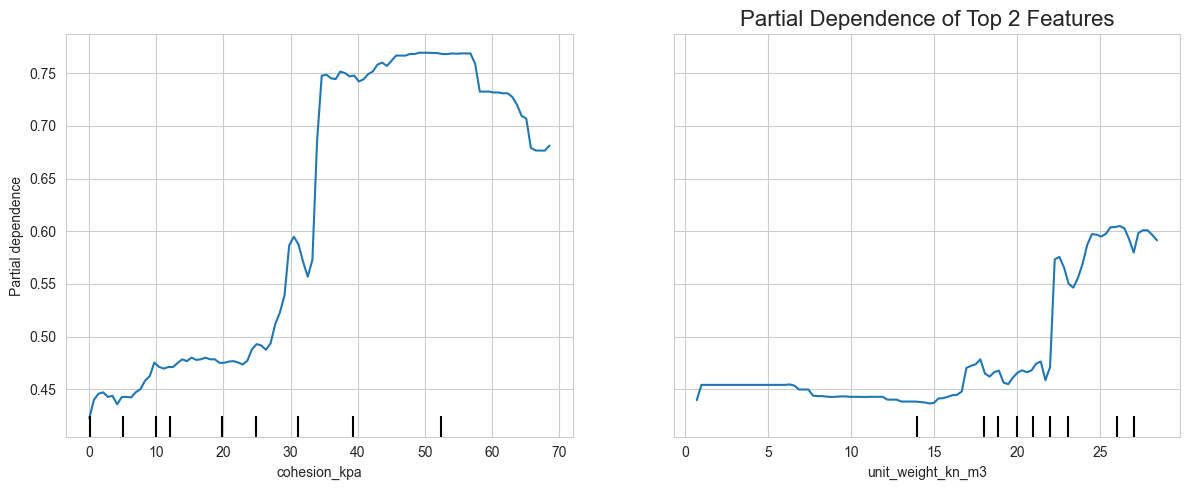

In [16]:
# --- Step 12: Feature Importance & PDP (Random Forest) ---
# This section now gracefully skips if RF was not trained
if "Random Forest" in trained_models:
    print("\n--- Feature Importances from Random Forest ---")
    rf_pipeline = trained_models["Random Forest"]

    # Check if 'model' step exists and has the attribute
    if 'model' in rf_pipeline.named_steps and hasattr(rf_pipeline.named_steps['model'], "feature_importances_"):
        rf_base_model = rf_pipeline.named_steps['model']
        importances = rf_base_model.feature_importances_
        feature_names = X_train.columns
        feat_imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values(by="Importance", ascending=False)
        print(feat_imp_df)

        plt.figure(figsize=(10, 6))
        sns.barplot(x="Importance", y="Feature", data=feat_imp_df)
        plt.title("Feature Importances from Random Forest Model", fontsize=16)
        plt.xlabel("Importance", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.tight_layout()
        plt.savefig(PLOTS_DIR/"feature_importance.png")
        plt.show()

        # --- Step 13: Partial Dependence Plots (PDP) ---
        from sklearn.inspection import PartialDependenceDisplay
        top_2_features = feat_imp_df["Feature"].head(2).tolist()
        print(f"\n--- Generating Partial Dependence Plots for: {top_2_features} ---")
        fig, ax = plt.subplots(figsize=(12, 5))
        PartialDependenceDisplay.from_estimator(rf_pipeline, X_train, features=top_2_features, ax=ax)
        plt.title("Partial Dependence of Top 2 Features", fontsize=16)
        plt.tight_layout()
        plt.savefig(PLOTS_DIR/"pdp_top2.png")
        plt.show()
    else:
        print("Could not get feature importances from RF model (unexpected pipeline structure).")
else:
    print("\nRandom Forest not in trained models; skipping Feature Importance and PDP.")

In [17]:
# --- Step 14: Optional SHAP Explainability (tries import; skips if unavailable) ---
try:
    import shap
    shap.logger.setLevel("ERROR")
    print("\nSHAP available — generating plots for tree models (small sample).")

    # Prefer champion if it is tree-based; else RandomForest if available
    shap_model_pipeline = None
    shap_name = None

    # Check if champion is a pipeline with a 'model' step that's tree-based
    if isinstance(champion_model_pipeline, Pipeline) and hasattr(champion_model_pipeline.named_steps.get('model', object()), 'feature_importances_'):
        shap_model_pipeline = champion_model_pipeline
        shap_name = champion_name
    elif "Random Forest" in trained_models: # Fallback to RF
        shap_model_pipeline = trained_models["Random Forest"]
        shap_name = "Random Forest"

    if shap_model_pipeline is not None:
        # Get the actual model object from the pipeline
        shap_model_obj = shap_model_pipeline.named_steps['model']

        # Check if a scaler exists (for SHAP KernelExplainer if needed, but TreeExplainer works on unscaled)
        if 'scaler' in shap_model_pipeline.named_steps:
            print(f"Note: SHAP is explaining the model ({shap_name}) *after* scaling.")
            X_train_transformed = shap_model_pipeline.named_steps['scaler'].transform(X_train)
            X_train_shap = pd.DataFrame(X_train_transformed, columns=X.columns)
        else:
            X_train_shap = X_train

        explainer = shap.TreeExplainer(shap_model_obj)
        # Use a modest sample for speed
        sample = X_train_shap.sample(min(200, len(X_train_shap)), random_state=42)
        shap_values = explainer.shap_values(sample)

        # SHAP summary plot for class 1 (Stability)
        plt.figure()
        shap.summary_plot(shap_values[1], sample, show=False)
        plt.title(f"SHAP Summary (Predicting 'Stable') - {shap_name}")
        plt.tight_layout()
        plt.savefig(PLOTS_DIR/"shap_summary.png")
        plt.close()
        print(f"SHAP summary saved for {shap_name}.")
    else:
        print("No suitable tree model for SHAP; skipping.")
except Exception as e:
    print(f"SHAP not available or failed (skipping): {e}")

SHAP not available or failed (skipping): module 'shap' has no attribute 'logger'


In [18]:
# --- Step 15: Persist final champion model ---
final_model_path = MODELS_DIR / "final_champion.pkl"
dump(champion_model_pipeline, final_model_path)
print(f"\nSaved final champion ({champion_name}) to: {final_model_path}")


Saved final champion (Random Forest) to: models\final_champion.pkl


In [19]:
# --- Step 16: Bundle a simple PDF report with all plots ---
print("\nGenerating PDF report...")

# Find all PNG files in the plots directory
plot_files = sorted(list(PLOTS_DIR.glob("*.png")))

pdf_path = REPORTS_DIR/"slope_stability_report.pdf"
with PdfPages(pdf_path) as pdf:
    for img_path in plot_files:
        if not img_path.exists():
            continue

        # Create a new figure and show the image
        fig = plt.figure(figsize=(11, 8.5)) # Standard letter paper size (approx)
        img = plt.imread(str(img_path))
        plt.imshow(img)
        plt.axis('off')
        plt.title(img_path.stem.replace("_", " ").title(), y=1.05) # Use filename as title

        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

print(f"PDF report saved to: {pdf_path}")
print("\n--- Script Complete ---")


Generating PDF report...
PDF report saved to: reports\slope_stability_report.pdf

--- Script Complete ---


**Interpretation of PDPs:**

- As shear strength parameters (e.g., higher friction angle / cohesion) increase, the predicted probability of stability should increase.
- Higher pore pressure ratio typically reduces stability — confirm that trend visually here.

*Final champion:* the top row in `results_df_final` (often the **Stacking Ensemble** or **Random Forest**).